In [ ]:
!pip install tensorflow keras numpy matplotlib scikit-learn seaborn tabulate

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import drive

In [ ]:
# Set constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
KFOLDS = 5

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the dataset paths
train_dataset_path = '/content/drive/My Drive/Training'
test_dataset_path = '/content/drive/My Drive/Testing'

Mounted at /content/drive


In [ ]:
# Load and preprocess data
def load_data(dataset_path):
    X, y = [], []
    class_names = os.listdir(dataset_path)
    class_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(class_map[class_name])
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    y = np.array(y)
    return X, y, class_map


# Load training data
X_train, y_train, class_map = load_data(train_dataset_path)
print(f"Training Data loaded. Total samples: {len(y_train)}, Classes: {class_map}")

# Load testing data
X_test, y_test, _ = load_data(test_dataset_path)
print(f"Testing Data loaded. Total samples: {len(y_test)}")

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Training Data loaded. Total samples: 5742, Classes: {'notumor': 0, 'Glioma': 1, 'Meningioma': 2, 'Pituitary': 3}
Testing Data loaded. Total samples: 1311


In [ ]:
# Define CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  # Added another convolutional layer
        MaxPooling2D((2, 2)),                   # Added another max pooling layer
        Flatten(),
        Dense(256, activation='relu'),        # Increased the number of neurons
        Dropout(0.5),                          # Increased Dropout
        Dense(4, activation='softmax')
    ])
    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# k-Fold Cross-Validation
kf = KFold(n_splits=KFOLDS, shuffle=True)
fold_no = 1
history_list = []

for train_idx, val_idx in kf.split(X_train):  # Split X_train instead of X
    print(f"Training on Fold {fold_no}")
    model = create_model()
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]  # Use X_train for splitting
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]  # Use y_train for splitting

    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
    datagen.fit(X_train_fold)

    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=BATCH_SIZE),
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=EPOCHS)
    history_list.append(history)
    fold_no += 1

Training on Fold 1
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.4419 - loss: 1.1693 - val_accuracy: 0.4517 - val_loss: 1.3504
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6290 - loss: 0.8794 - val_accuracy: 0.6614 - val_loss: 0.8558
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6960 - loss: 0.7818 - val_accuracy: 0.5901 - val_loss: 1.0334
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7098 - loss: 0.7249 - val_accuracy: 0.4265 - val_loss: 2.0909
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7492 - loss: 0.6435 - val_accuracy: 0.6754 - val_loss: 0.8567
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7582 - loss: 0.6066 - val_accuracy: 0.6919 - val_loss: 0.7492
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7687 - loss: 0.5763 - val_accuracy: 0.7781 - val_loss: 0.5628
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7729 - lo

Final Training Accuracy: 87.68%
Final Validation Accuracy: 87.89%
Final Training Loss: 0.3365
Final Validation Loss: 0.3744


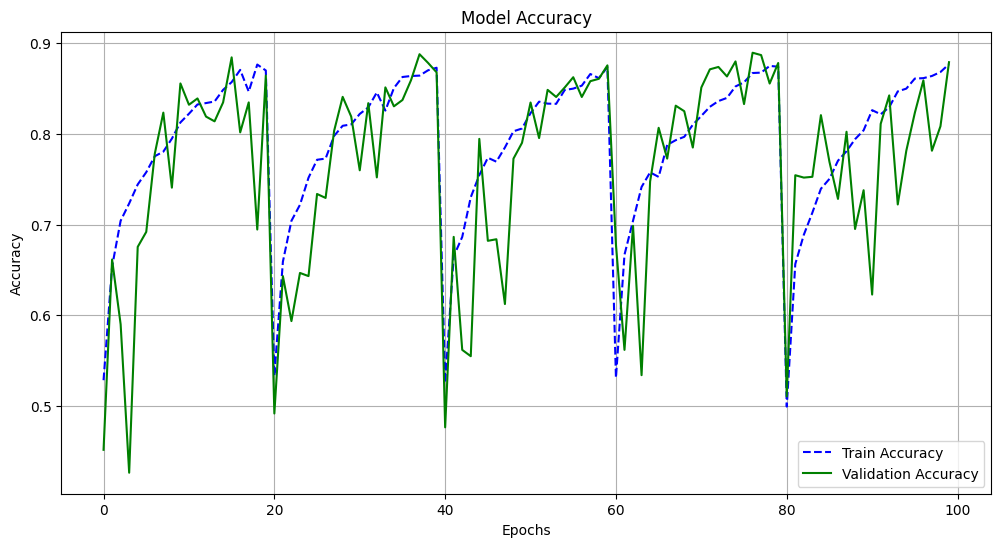

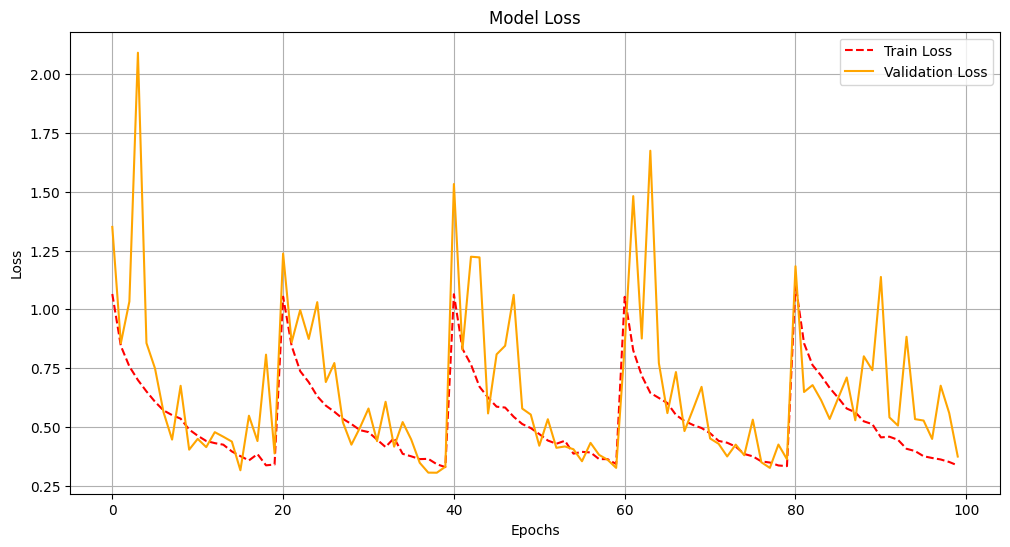

In [ ]:
# Plot metrics
def plot_metrics(history_list):
    acc, val_acc, loss, val_loss = [], [], [], []
    for history in history_list:
        acc += history.history['accuracy']
        val_acc += history.history['val_accuracy']
        loss += history.history['loss']
        val_loss += history.history['val_loss']

    final_train_accuracy = acc[-1] * 100
    final_val_accuracy = val_acc[-1] * 100
    final_train_loss = loss[-1]
    final_val_loss = val_loss[-1]

    print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(acc, label='Train Accuracy', color='blue', linestyle='--')
    plt.plot(val_acc, label='Validation Accuracy', color='green')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Train Loss', color='red', linestyle='--')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(history_list)

In [ ]:
# Save the model after training
model.save('/content/drive/My Drive/classification.h5')  # Save in .h5 format

# Save the class_map using pickle
import pickle
with open('/content/drive/My Drive/classification_class_map.pkl', 'wb') as f:
    pickle.dump(class_map, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


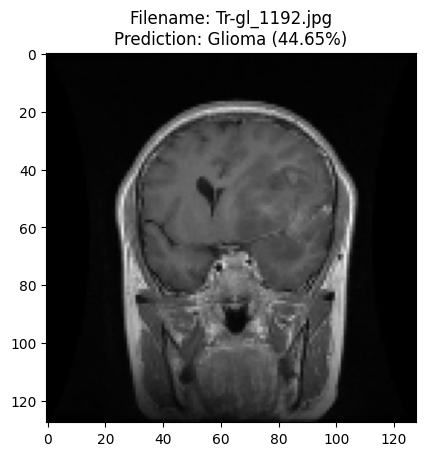

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


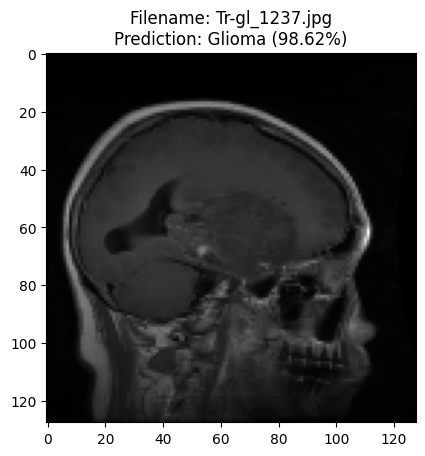

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


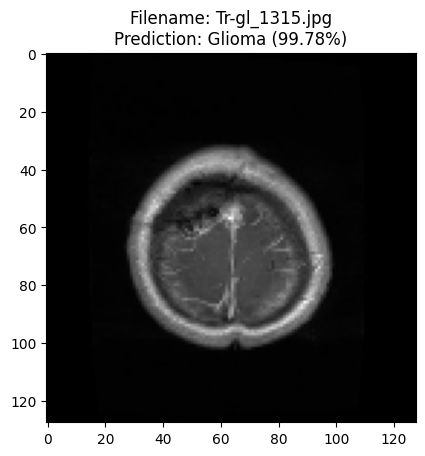

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


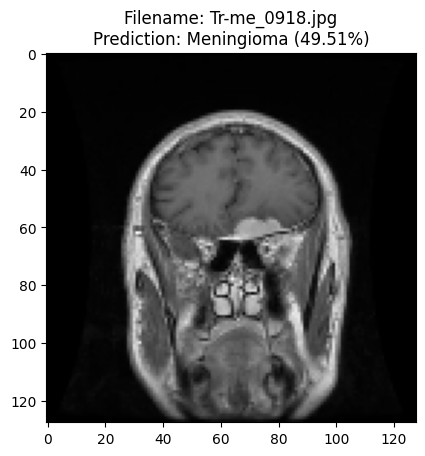

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


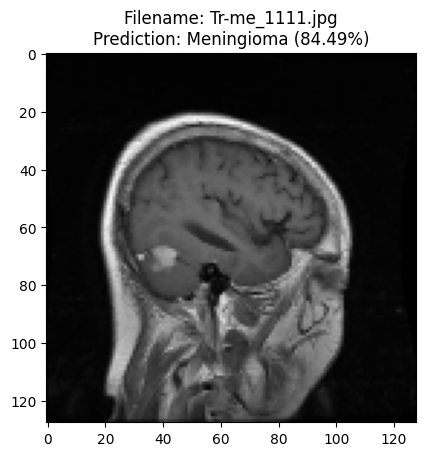

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


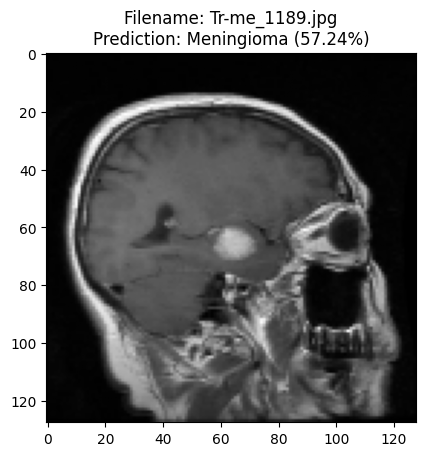

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


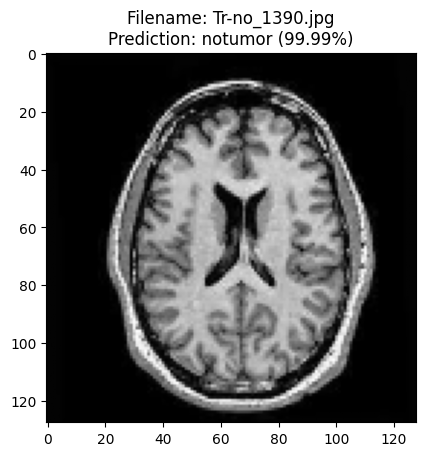

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


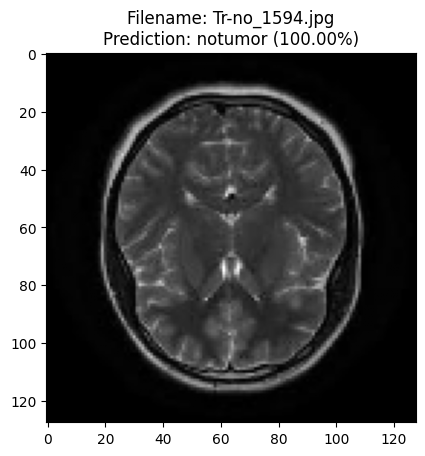

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


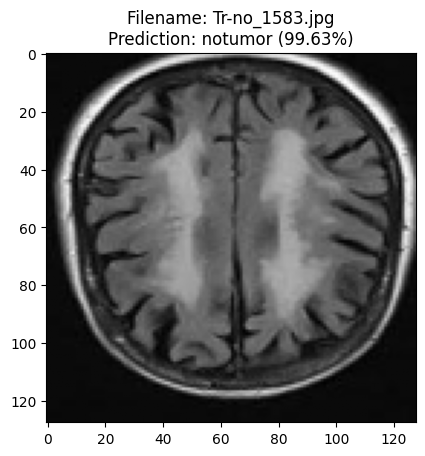

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


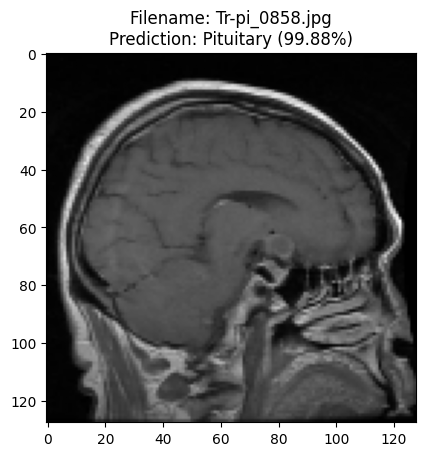

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


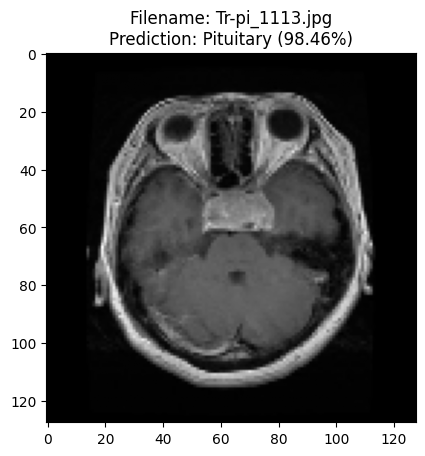

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


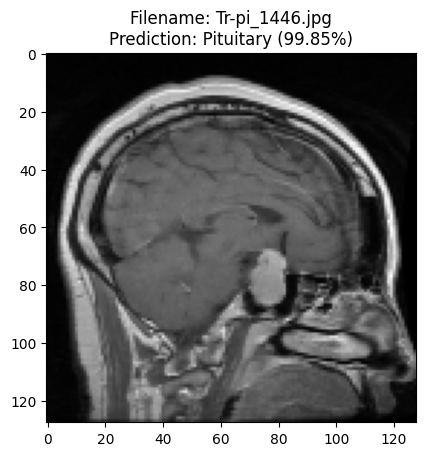

+----------------+-------------------+--------------+
| File Name      | Predicted Class   | Confidence   |
+================+===================+==============+
| Tr-gl_1192.jpg | Glioma            | 44.65%       |
+----------------+-------------------+--------------+
| Tr-gl_1237.jpg | Glioma            | 98.62%       |
+----------------+-------------------+--------------+
| Tr-gl_1315.jpg | Glioma            | 99.78%       |
+----------------+-------------------+--------------+
| Tr-me_0918.jpg | Meningioma        | 49.51%       |
+----------------+-------------------+--------------+
| Tr-me_1111.jpg | Meningioma        | 84.49%       |
+----------------+-------------------+--------------+
| Tr-me_1189.jpg | Meningioma        | 57.24%       |
+----------------+-------------------+--------------+
| Tr-no_1390.jpg | notumor           | 99.99%       |
+----------------+-------------------+--------------+
| Tr-no_1594.jpg | notumor           | 100.00%      |
+----------------+----------

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,486 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)



--- Model Architecture and Layers ---
Layer 1: conv2d_26 - Type: Conv2D, Output Shape: (None, 126, 126, 32)
Layer 2: max_pooling2d_26 - Type: MaxPooling2D, Output Shape: (None, 63, 63, 32)
Layer 3: conv2d_27 - Type: Conv2D, Output Shape: (None, 61, 61, 64)
Layer 4: max_pooling2d_27 - Type: MaxPooling2D, Output Shape: (None, 30, 30, 64)
Layer 5: conv2d_28 - Type: Conv2D, Output Shape: (None, 28, 28, 128)
Layer 6: max_pooling2d_28 - Type: MaxPooling2D, Output Shape: (None, 14, 14, 128)
Layer 7: flatten_11 - Type: Flatten, Output Shape: (None, 25088)
Layer 8: dense_22 - Type: Dense, Output Shape: (None, 256)
Layer 9: dropout_11 - Type: Dropout, Output Shape: (None, 256)
Layer 10: dense_23 - Type: Dense, Output Shape: (None, 4)

--- Image Preprocessing ---
Images are resized to 128x128 pixels and converted to grayscale.
Pixel values are normalized to the range [0, 1] by dividing by 255.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os
from tabulate import tabulate
import json
from google.colab import drive
from sklearn.cluster import KMeans

# Mount Google Drive to ensure access
drive.mount('/content/drive')

# Define paths
model_path = '/content/drive/My Drive/classification.h5'
test_folder = '/content/drive/My Drive/Test/'

# Load the trained model
model = load_model(model_path)

# Use the provided class_map
class_map = {'notumor': 0, 'Glioma': 1, 'Meningioma': 2, 'Pituitary': 3}

# Image size
IMG_SIZE = 128

# Create a list to store prediction results
results = []

# Iterate through images in the test folder
for filename in os.listdir(test_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
        img_path = os.path.join(test_folder, filename)

        # Load and preprocess the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0

        # Make prediction
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction)

        # Get class name from class_map
        predicted_class = list(class_map.keys())[list(class_map.values()).index(predicted_class_index)]
        confidence = np.max(prediction) * 100

        # Append results
        results.append([filename, predicted_class, f"{confidence:.2f}%"])

        # Display the image with prediction and filename in the title
        plt.imshow(img.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title(f"Filename: {filename}\nPrediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

# Display predictions in a tabular form
headers = ["File Name", "Predicted Class", "Confidence"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# Print model summary
model.summary()

# Additional Report Information
print("\n\n--- Model Architecture and Layers ---")
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1}: {layer.name} - Type: {layer.__class__.__name__}, Output Shape: {layer.output.shape}")

print("\n--- Image Preprocessing ---")
print(f"Images are resized to {IMG_SIZE}x{IMG_SIZE} pixels and converted to grayscale.")
print("Pixel values are normalized to the range [0, 1] by dividing by 255.")

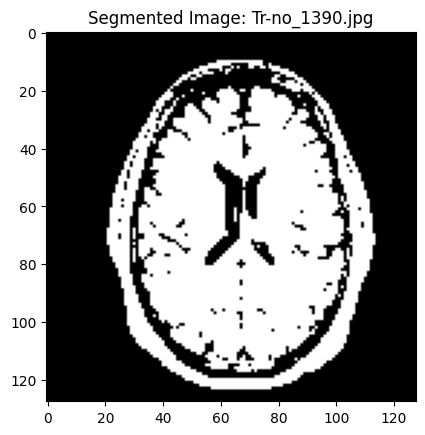

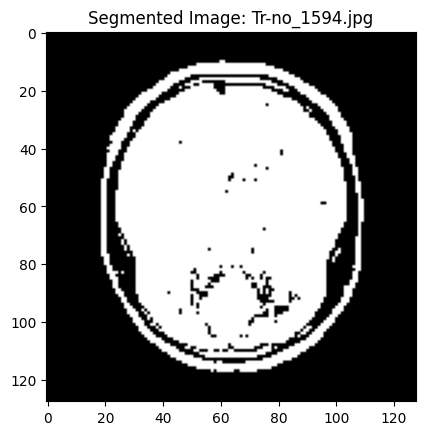

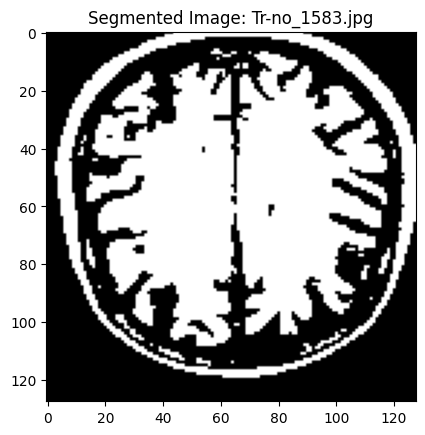

+----------------+-----------+
| File Name      | Status    |
+================+===========+
| Tr-no_1390.jpg | Segmented |
+----------------+-----------+
| Tr-no_1594.jpg | Segmented |
+----------------+-----------+
| Tr-no_1583.jpg | Segmented |
+----------------+-----------+


In [ ]:
# ------------------ Image Segmentation using PSO ------------------

def pso_thresholding(image, num_particles=30, max_iterations=100):
    height, width = image.shape
    best_threshold = 0
    best_fitness = -np.inf

    # Initialize particles randomly
    particles = np.random.randint(0, 256, size=num_particles)
    velocities = np.zeros(num_particles)
    personal_best = np.copy(particles)
    personal_best_fitness = np.zeros(num_particles)

    # Fitness function (Otsu's method)
    def fitness_function(threshold):
        foreground = image > threshold
        background = image <= threshold
        if np.sum(foreground) == 0 or np.sum(background) == 0:
            return 0
        w0 = np.sum(background) / (height * width)
        w1 = np.sum(foreground) / (height * width)
        mean0 = np.mean(image[background]) if np.sum(background) > 0 else 0
        mean1 = np.mean(image[foreground]) if np.sum(foreground) > 0 else 0
        return w0 * w1 * (mean0 - mean1) ** 2

    # Evaluate initial fitness
    for i in range(num_particles):
        personal_best_fitness[i] = fitness_function(particles[i])
        if personal_best_fitness[i] > best_fitness:
            best_fitness = personal_best_fitness[i]
            best_threshold = particles[i]

    # PSO optimization loop
    inertia_weight = 0.7
    cognitive_coeff = 1.5
    social_coeff = 1.5

    for _ in range(max_iterations):
        for i in range(num_particles):
            # Update velocity
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (inertia_weight * velocities[i] +
                             cognitive_coeff * r1 * (personal_best[i] - particles[i]) +
                             social_coeff * r2 * (best_threshold - particles[i]))
            # Update particle position
            particles[i] = int(particles[i] + velocities[i])
            particles[i] = max(0, min(255, particles[i]))  # Keep within valid threshold range

            # Evaluate new fitness
            current_fitness = fitness_function(particles[i])
            if current_fitness > personal_best_fitness[i]:
                personal_best[i] = particles[i]
                personal_best_fitness[i] = current_fitness

            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_threshold = particles[i]

    # Apply threshold to segment image
    segmented_img = np.where(image > best_threshold, 255, 0).astype(np.uint8)
    return segmented_img

# Apply segmentation only on "No Tumor" images
segmented_results = []
for filename, predicted_class, confidence in results:
    if predicted_class == "notumor":
        img_path = os.path.join(test_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Apply PSO-based segmentation
        segmented_img = pso_thresholding(img)

        plt.imshow(segmented_img, cmap='gray')
        plt.title(f"Segmented Image: {filename}")
        plt.show()

        segmented_results.append([filename, "Segmented"])

# Display segmentation results
print(tabulate(segmented_results, headers=["File Name", "Status"], tablefmt="grid"))